## TELECOM CUSTOMER CHURN MODELLING

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telecom-churn/Telecom_churn.csv


---
## External Utilities

In [2]:
from sklearn import set_config
set_config(display='diagram')
import warnings
warnings.filterwarnings('ignore')
import missingno
from xgboost import XGBRegressor
from matplotlib import rcParams
import pickle


---
## ***`Machine Learning Development Life Cycle`*** 
*By Saumya Shah*

- EDA (Iterative until Modelling)
- Imputation 
- Feature Selection
- Dealing with outliers




- Hypothesis Testing
- Feature Transformation
- Feature Extraction
- Data Resampling



- Machine Learning Modelling
- Model Selection
- Validating
- Pipelining



- Development
- Testing
- MLOPS pipeline (Docker and Kubernetes)
- Deployment (AWS)

---


In [3]:
df = pd.read_csv('/kaggle/input/telecom-churn/Telecom_churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

---
## ***Some points to ponder upon***

- We don't need Customer ID and Payment Method for analysis or modelling as our model needs to take unbiased decisions.
- Consider SeniorCitizen as a category.
- *Hypothesis* : "TotalCharges" depend heavily on the type of contract. We need to standardize a contract to evaluate the churn. We believe that tenure is in number of months. We multiply it with monthly charges and find whether it's close to TotalCharges. 
- The target column "Churn", is imbalanced. We would need to upsample the inputs having "yes" in the target column. 

---

In [5]:
#df = df.iloc[:,1:]
df.pop("customerID")
df.pop("PaymentMethod")
df.pop("PaperlessBilling")
df.head()
print(df.shape)

(7043, 18)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  MonthlyCharges    7043 non-null   float64
 16  TotalCharges      7043 non-null   float64


In [7]:
all_categorical_df = df.copy()
all_categorical_df.pop("MonthlyCharges")
all_categorical_df.pop("TotalCharges")
all_categorical_df.pop("tenure")
print(all_categorical_df.shape)

(7043, 15)


In [8]:
all_categorical_df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,Churn
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,No
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes


In [9]:
all_numeric_df = df[["tenure", "MonthlyCharges", "TotalCharges"]]
print(all_numeric_df.shape)
all_numeric_df.head()


(7043, 3)


,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


In [10]:
columnsNumeric = all_numeric_df.columns
columnsCategorical = all_categorical_df.columns
columnsCategorical, columnsNumeric

(Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
        'Contract', 'Churn'],
       dtype='object'),
 Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object'))

---
## ***EDA | Phase 1***

---
### Univariate Analysis

In [11]:
# for i in enumerate(columnsCategorical):
#     print(i)

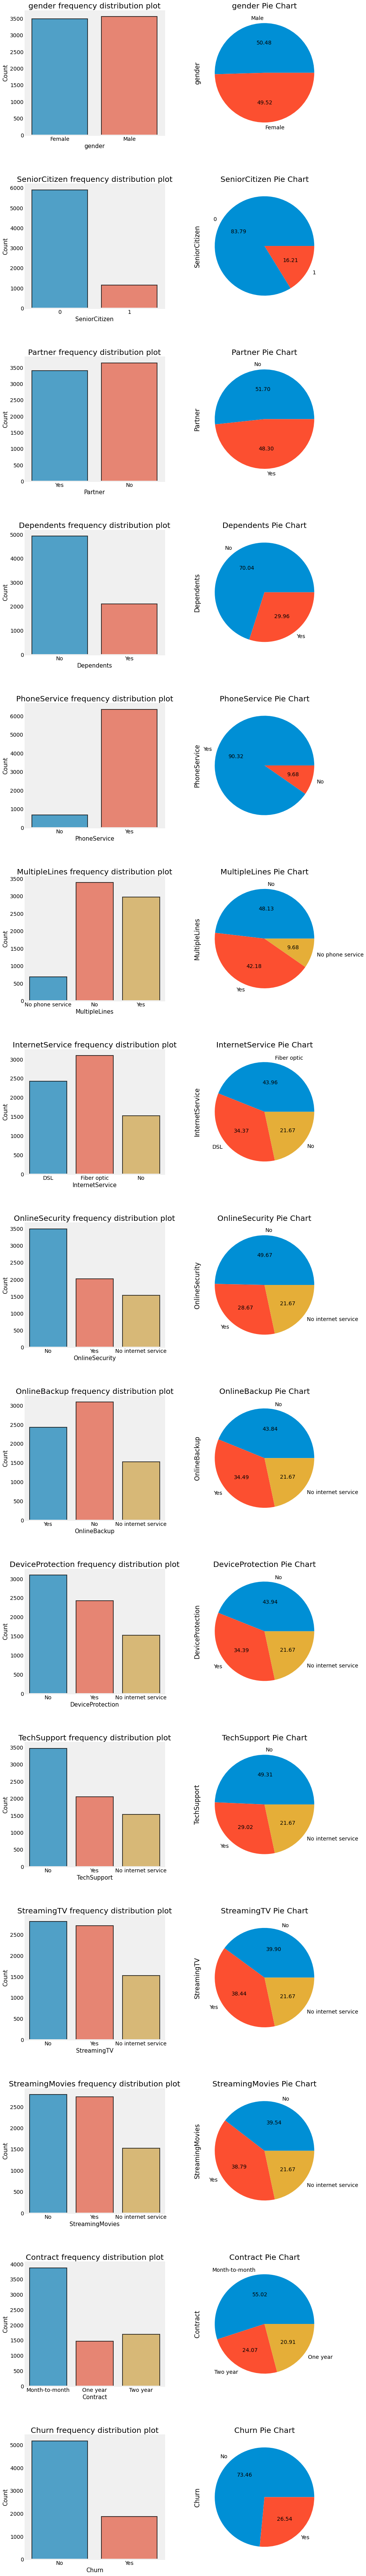

In [12]:
plt.figure(figsize=(15,95))
for i in enumerate(columnsCategorical):
    plt.style.use('fivethirtyeight')
    plt.subplot(15,2,(2*i[0])+1)
    sns.countplot(all_categorical_df[i[1]],alpha=0.75,edgecolor='black',linewidth=2)
    plt.title(f'{i[1]} frequency distribution plot',fontsize=20)
    plt.xlabel(f'{i[1]}',fontsize=15)
    plt.ylabel('Count',fontsize=15)
    plt.tight_layout(pad=5.0)
    plt.grid(False)
    
    
    plt.subplot(15,2,(2*i[0])+2)
    all_categorical_df[i[1]].value_counts().plot(kind  = 'pie', autopct = '%.2f')
    plt.title(f'{i[1]} Pie Chart',fontsize=20)
    plt.tight_layout(pad=5.0)
    


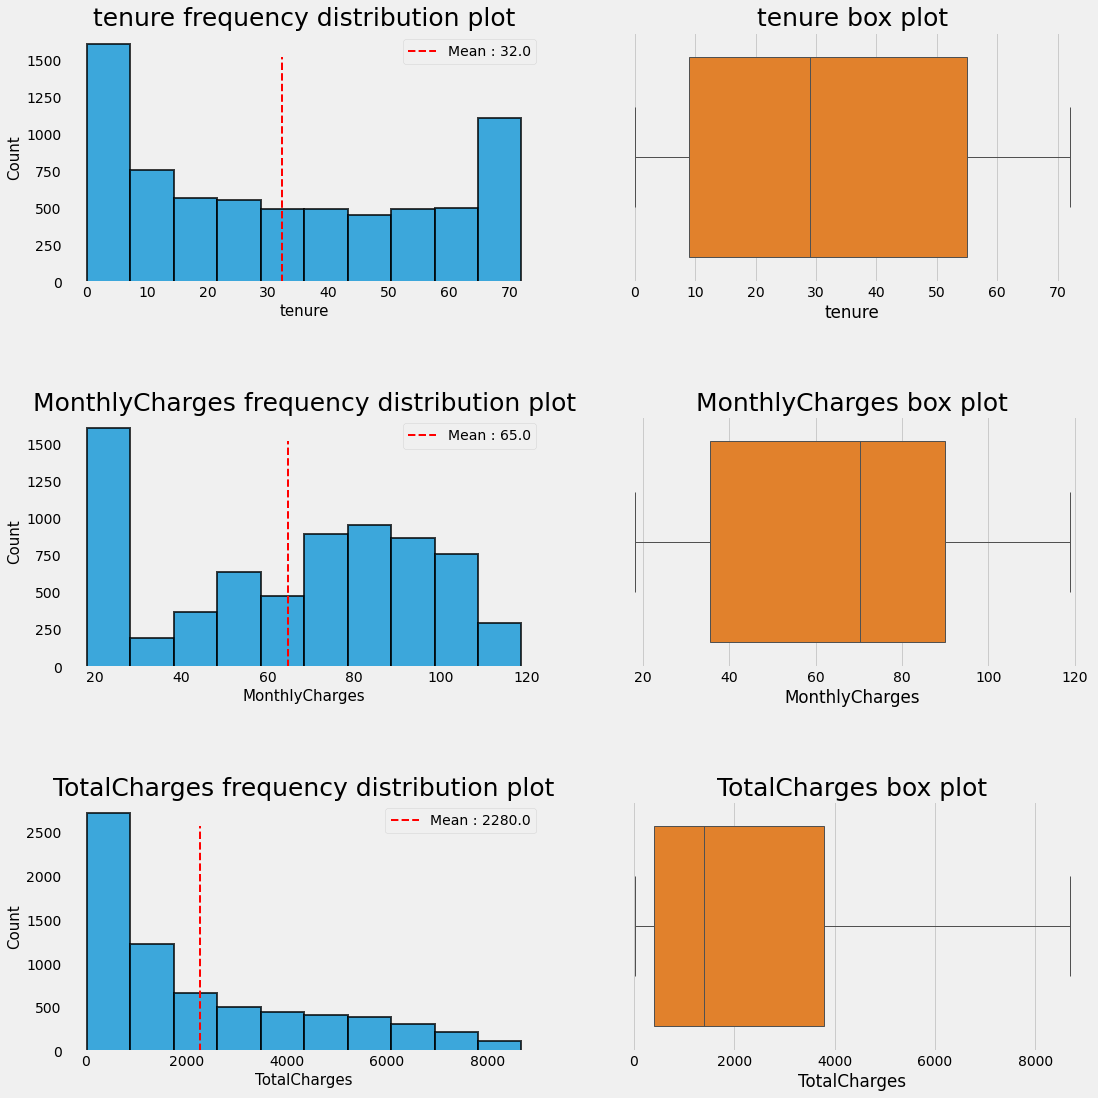

In [13]:
plt.figure(figsize=(17,17))
for i in enumerate(columnsNumeric):
    plt.style.use('fivethirtyeight')
    plt.subplot(3,2,(2*i[0])+1)
    plt.hist(all_numeric_df[i[1]],alpha=0.75,edgecolor='black',linewidth=2)
    plt.axvline(x = all_numeric_df[i[1]].mean(), linewidth=2, color = 'r', ls = "--", label="Mean : "+str(np.round_(np.mean(all_numeric_df[i[1]]))), ymax = 0.9)
    plt.title(f'{i[1]} frequency distribution plot',fontsize=25)
    plt.xlabel(f'{i[1]}',fontsize=15)
    plt.ylabel('Count',fontsize=15)
    plt.tight_layout(pad=3.0)
    plt.legend()
    plt.grid(False)
    
    plt.subplot(3,2,(2*i[0])+2)

    sns.boxplot(all_numeric_df[i[1]],color='tab:orange',linewidth=1)
    plt.title(f'{i[1]} box plot',fontsize=25)
    plt.tight_layout(pad=5.0)

### Bivariate analysis

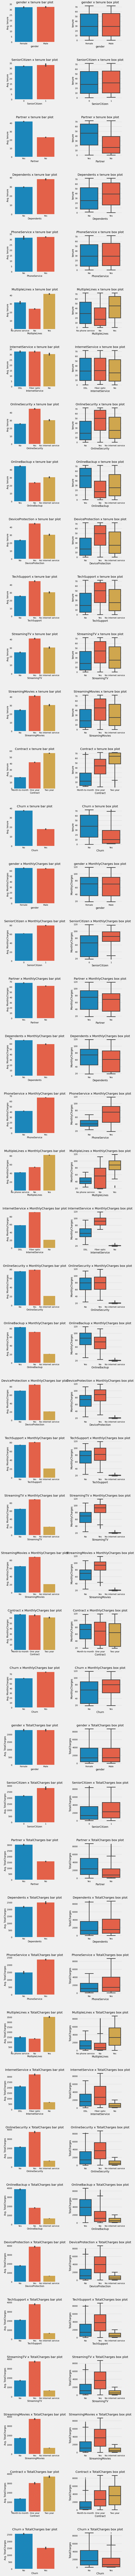

In [14]:
counter =1 
plt.figure(figsize=(13,240))
for i in enumerate(columnsNumeric):
    for j in enumerate(columnsCategorical):
        #print(len(i))
        plt.style.use('fivethirtyeight')
        plt.subplot(45,2,counter)
        sns.barplot(all_categorical_df[j[1]],all_numeric_df[i[1]])
        plt.title(f'{j[1]} x {i[1]} bar plot',fontsize=20)
        plt.xlabel(f'{j[1]}',fontsize=15)
        plt.ylabel(f'Avg. {i[1]}',fontsize=15)
        plt.tight_layout(pad=3.0)
        plt.grid(False)
        
        
        plt.subplot(45,2,counter+1)
        sns.boxplot(all_categorical_df[j[1]],all_numeric_df[i[1]])
        plt.title(f'{j[1]} x {i[1]} box plot',fontsize=20)
        plt.tight_layout(pad=5.0)
        
        counter+=2
        
        
        
        

---
## ***Some points to ponder upon***

- We need to separately analyze the data where there is no internet service
- *Heuristic* : We need to take care of the data of "senior citizens and people with no phone service"
- What about missing values and outlier ?
___

## ***Any missing values ?***

In [15]:
print(df.isnull().sum(axis = 0))

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


---
## ***Feature Selection***

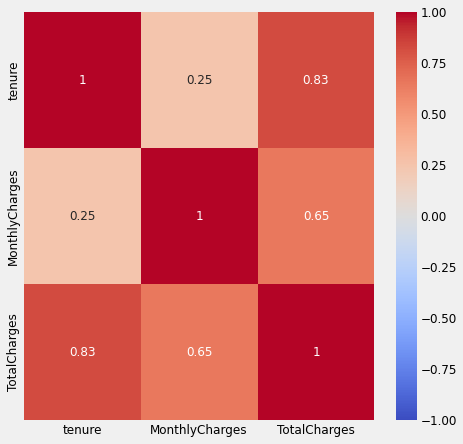

In [16]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(all_numeric_df.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', ax=ax);

#### ***`Tenure`*** and ***`Total Charges`*** are highly correlated and it can be interpreted that one of them is redundant. Since we do not know much about the tenure (there are multiple contract types available), we decide to remove the ***`Tenure`*** column.

In [17]:
all_numeric_df.pop('tenure')
df.pop('tenure')
df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,56.95,1889.50,No
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,42.30,1840.75,No
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,70.70,151.65,Yes


In [18]:
print(df.shape)
print(all_numeric_df.shape)

(7043, 17)
(7043, 2)


---

## ***Hypothesis Testing***

***`Null Hypothesis`*** :

*In the input data, the `contract` column might be of an ordinal category `(good -> better -> best)` whereas others might be nominal data `(jan == feb == march)`*

***`Alternate Hypothesis`*** : 

*The `contract` column contains nominal categorical data `(Monthly customers == 1 Year customers == 2 Year customers)`*

*For this test, we are going to judge the customer based on two parameters :* `RETENTION` and `REVENUE`.

In [19]:
# Percentage of contract people leaving the service
print(df[df['Churn'] == "Yes"].shape)
print()
print(df[df['Contract'] == "Month-to-month"].shape)
print(df[df['Contract'] == "One year"].shape)
print(df[df['Contract'] == "Two year"].shape)
print()
print(df[(df['Contract'] == "Month-to-month") & (df['Churn'] == "Yes")].shape)
print(df[(df["Churn"]=="Yes") & (df['Contract'] == "One year")].shape)
print(df[(df["Churn"]=="Yes") & (df['Contract'] == "Two year")].shape)

(1869, 17)

(3875, 17)
(1473, 17)
(1695, 17)

(1655, 17)
(166, 17)
(48, 17)


In [20]:
#print(df[(df["Churn"]=="Yes") & (df['Contract'] == "One year")].shape)
ratioM2Mchurn = 1655/3875
ratio1Yrchurn = 166/1473
ratio2Yrchurn = 48/1695

ratioM2Mchurn, ratio1Yrchurn, ratio2Yrchurn

(0.4270967741935484, 0.11269517990495587, 0.02831858407079646)

**`RETENTION(Month-to-month customers) < RETENTION(One year customers) < RETENTION(Two year customers)`**

In [21]:
# Average revenue by contract

df[['Contract', 'MonthlyCharges', 'TotalCharges']].groupby(['Contract']).sum()
usrMonthlyRevenueM2M = 257294.15/3875
usrTotalRevenueM2M = 5305861.5/3875

usrMonthlyRevenue1Yr = 95816.60/1473
usrTotalRevenue1Yr = 4467073.2/1473

usrMonthlyRevenue2Yr = 103005.85/1695
usrTotalRevenue2Yr = 6283689.6/1695

print(usrMonthlyRevenueM2M, usrMonthlyRevenue1Yr, usrMonthlyRevenue2Yr)
print()
print(usrTotalRevenueM2M, usrTotalRevenue1Yr, usrTotalRevenue2Yr)

66.39849032258064 65.04860828241684 60.770412979351036

1369.2545806451612 3032.636252545825 3707.1915044247785


*For any firm, customers who contribute more towards total revenue are of more concern*

**`REVENUE(Month-to-month customers) < REVENUE(One year customers) < REVENUE(Two year customers)`**

#### ***Our hypothesis Testing rejects the alternate hypothesis. It is evident that :***

#### **`IMPORTANCE(Month-to-month customers) < IMPORTANCE(One year customers) < IMPORTANCE(One year customers)`**

---
## ***Character Encoding***

In [22]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

***We rearrange the columns to automate the process of column transformations***

In [23]:
df = df[['gender', 'Partner', 'Dependents', 'PhoneService','MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup','DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies','Contract', 'SeniorCitizen', 'MonthlyCharges', 'TotalCharges', 'Churn']]
df.head()

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,SeniorCitizen,MonthlyCharges,TotalCharges,Churn
0,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,0,29.85,29.85,No
1,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,0,56.95,1889.50,No
2,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,0,53.85,108.15,Yes
3,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,42.30,1840.75,No
4,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,0,70.70,151.65,Yes


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   Partner           7043 non-null   object 
 2   Dependents        7043 non-null   object 
 3   PhoneService      7043 non-null   object 
 4   MultipleLines     7043 non-null   object 
 5   InternetService   7043 non-null   object 
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  StreamingTV       7043 non-null   object 
 11  StreamingMovies   7043 non-null   object 
 12  Contract          7043 non-null   object 
 13  SeniorCitizen     7043 non-null   int64  
 14  MonthlyCharges    7043 non-null   float64
 15  TotalCharges      7043 non-null   float64
 16  Churn             7043 non-null   object 


In [25]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size = 0.2, random_state = 42)

X_train_pipe = X_train.copy()
y_train_pipe = y_train.copy()
X_test_pipe = X_test.copy()
y_test_pipe = y_test.copy()

transformer = ColumnTransformer(transformers = [
    ('ohe', OneHotEncoder(sparse = False, drop='first'), slice(0,12)),
    ('oe', OrdinalEncoder(categories = [["Month-to-month", "One year", "Two year"]]),['Contract'])
], remainder = 'passthrough')

X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [26]:
X_train

array([[0.00000e+00, 0.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        6.48500e+01, 1.33680e+03],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        9.72000e+01, 5.12945e+03],
       [1.00000e+00, 1.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        2.34500e+01, 2.34500e+01],
       ...,
       [1.00000e+00, 1.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        2.11500e+01, 3.06050e+02],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 1.00000e+00,
        9.94500e+01, 1.20015e+03],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        1.98000e+01, 4.57300e+02]])

In [27]:
df.Churn.replace(to_replace=['Yes', 'No'], value=[1, 0])
df.head()

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,SeniorCitizen,MonthlyCharges,TotalCharges,Churn
0,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,0,29.85,29.85,No
1,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,0,56.95,1889.50,No
2,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,0,53.85,108.15,Yes
3,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,42.30,1840.75,No
4,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,0,70.70,151.65,Yes


In [28]:
y_train = y_train.replace(to_replace=['Yes', 'No'], value=[1, 0])
y_train


2142    0
1623    0
6074    1
1362    1
6754    0
       ..
3772    1
5191    0
5226    0
5390    1
860     0
Name: Churn, Length: 5634, dtype: int64

In [29]:
y_test= y_test.replace(to_replace=['Yes', 'No'], value=[1, 0])
y_test

185     1
2715    0
3825    0
1807    1
132     0
       ..
6366    0
315     0
2439    0
5002    0
1161    1
Name: Churn, Length: 1409, dtype: int64

---
## ***Feature Extraction***

In [30]:
X_train_dummy = pd.get_dummies(df.iloc[:,:-1], drop_first=True)
y_train_dummy = pd.get_dummies(df.iloc[:,-1], drop_first=True)

In [31]:
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor()
model.fit(X_train_dummy, y_train_dummy)

ExtraTreesRegressor()

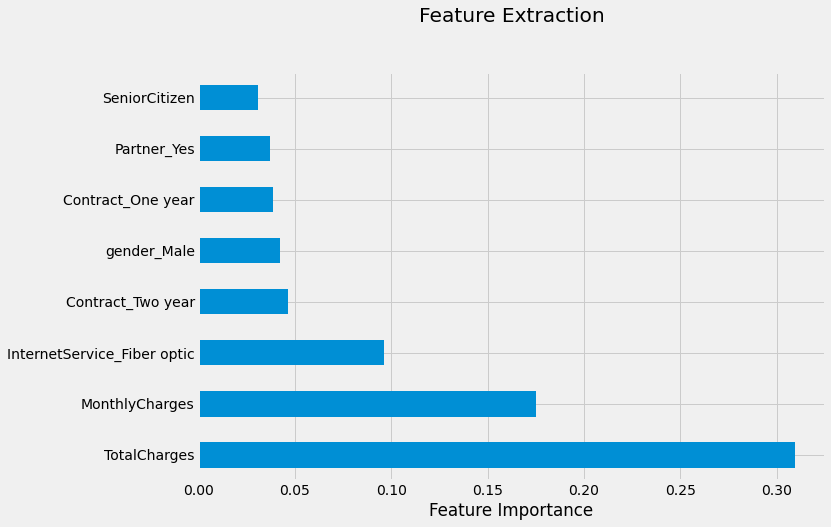

In [32]:
fig = plt.figure(figsize=(10,7))
plt.style.use('fivethirtyeight')
feature_imps = pd.Series(model.feature_importances_, index = X_train_dummy.columns)
feature_imps.nlargest(8).plot(kind='barh')
plt.grid(True)
plt.title("Feature Extraction", pad=50)
plt.xlabel('Feature Importance')
plt.show()

***Most important features are :***

- TotalCharges 
- MonthlyCharges 
- InternetService 
- Contract
- Gender

In [33]:
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 OneHotEncoder(drop='first', sparse=False),
                                 slice(0, 12, None)),
                                ('oe',
                                 OrdinalEncoder(categories=[['Month-to-month',
                                                             'One year',
                                                             'Two year']]),
                                 ['Contract'])])

---
## ***Upsampling***

*Since the data set is very imbalanced, we now `upsample` it using SMOTE Resampling. But our input data also has categorical values. Hence, we would a flavour of SMOTE called as `SMOTE-NC`*

In [34]:
from collections import Counter
print(f'Non- Resampled dataset samples per class {Counter(y_train)}')

Non- Resampled dataset samples per class Counter({0: 4138, 1: 1496})


In [35]:
from imblearn.over_sampling import SMOTENC

sm = SMOTENC(categorical_features=range(0,21), random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)


In [36]:
from collections import Counter
print(f'Resampled dataset samples per class {Counter(y_res)}')

Resampled dataset samples per class Counter({0: 4138, 1: 4138})


In [37]:
X_res.shape

(8276, 24)

In [38]:
X_res

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 6.48500000e+01, 1.33680000e+03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 9.72000000e+01, 5.12945000e+03],
       [1.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.34500000e+01, 2.34500000e+01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.05015845e+02, 3.54451484e+03],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.26898341e+01, 9.31004476e+02],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.69026257e-01, 7.61221253e+01, 1.88969990e+03]])

In [39]:
y_res = y_res.values

---

## ***ML Modelling***

1. Linear models
2. Kernel based models
3. Non-parameteric models
4. Bayesian models
5. Tree based models
6. Ensemble models

---
### ***Linear models***

#### ***Logistic Regression*** `Baseline`

In [40]:
from sklearn.linear_model import LogisticRegression
logistic_clf = LogisticRegression(solver='liblinear').fit(X_res, y_res)

In [41]:
from sklearn.model_selection import cross_val_score
print(f"{(cross_val_score(logistic_clf, X_res, y_res, cv=5, scoring='f1').mean())*100} % F1-Score")
print(f"{(cross_val_score(logistic_clf, X_res, y_res, cv=5, scoring='accuracy').mean())*100} % Accuracy")

78.9295945466271 % F1-Score
78.46825605324226 % Accuracy


---
### ***Kernel based models***

#### ***Support Vector machine*** `Baseline`

In [42]:
from sklearn.svm import SVC

svc_clf = SVC(kernel = 'rbf', gamma='auto').fit(X_res, y_res)
print(f"{(cross_val_score(svc_clf, X_res, y_res, cv=5, scoring='f1').mean())*100} % f1-score")
print(f"{(cross_val_score(svc_clf, X_res, y_res, cv=5, scoring='accuracy').mean())*100} % Accuracy")

77.51937333911177 % f1-score
78.2141731249179 % Accuracy


---
### ***Non-parameteric models***

#### ***K Nearest Neighbour*** `Baseline`

*We need to select an optimum value for K*

In [43]:
# provisional value of K
np.sqrt(X_res.shape[0])

90.97252332435328

In [44]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=91, weights = 'distance').fit(X_res, y_res)
print(f"{(cross_val_score(knn_clf, X_res, y_res, cv=5, scoring='f1').mean())*100} % f1-score")
print(f"{(cross_val_score(knn_clf, X_res, y_res, cv=5, scoring='accuracy').mean())*100} % Accuracy")

76.83284018640589 % f1-score
76.08760599559233 % Accuracy


---
### ***Bayesian models***

#### ***Bernoulli Naive Bayes*** `Baseline`

In [45]:
from sklearn.naive_bayes import BernoulliNB

bernoulli_clf = BernoulliNB().fit(X_res, y_res)
print(f"{(cross_val_score(bernoulli_clf, X_res, y_res, cv=5, scoring='f1').mean())*100} % f1-score")
print(f"{(cross_val_score(bernoulli_clf, X_res, y_res, cv=5, scoring='accuracy').mean())*100} % Accuracy")

78.89011685008968 % f1-score
76.75236802545353 % Accuracy


#### ***Gaussian Naive Bayes*** 

In [46]:
from sklearn.naive_bayes import GaussianNB
gaussian_clf = GaussianNB().fit(X_res, y_res)
print(f"{(cross_val_score(gaussian_clf, X_res, y_res, cv=5, scoring='f1').mean())*100} % f1-score")
print(f"{(cross_val_score(gaussian_clf, X_res, y_res, cv=5, scoring='accuracy').mean())*100} % Accuracy")

77.73020077956947 % f1-score
74.93979596304567 % Accuracy


#### ***Multinomial Naive Bayes*** 

In [47]:
from sklearn.naive_bayes import MultinomialNB
multinomial_clf = MultinomialNB().fit(X_res, y_res)
print(f"{(cross_val_score(multinomial_clf, X_res, y_res, cv=5, scoring='f1').mean())*100} % f1-score")
print(f"{(cross_val_score(multinomial_clf, X_res, y_res, cv=5, scoring='accuracy').mean())*100} % Accuracy")

71.52735514705275 % f1-score
70.0943415502722 % Accuracy


---
### ***Tree based models***

#### ***Decision Tree*** `Baseline`

In [48]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier().fit(X_res, y_res)
print(f"{(cross_val_score(dt_clf, X_res, y_res, cv=5, scoring='f1').mean())*100} % f1-score")
print(f"{(cross_val_score(dt_clf, X_res, y_res, cv=5, scoring='accuracy').mean())*100} % Accuracy")

77.63302666397192 % f1-score
78.65032035845118 % Accuracy


---
### ***Ensemble models***

#### ***Random Forest*** `Baseline`

In [49]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier().fit(X_res, y_res)
print(f"{(cross_val_score(dt_clf, X_res, y_res, cv=5, scoring='f1').mean())*100} % f1-score")
print(f"{(cross_val_score(dt_clf, X_res, y_res, cv=5, scoring='accuracy').mean())*100} % Accuracy")

77.46447514967716 % f1-score
78.60196009749404 % Accuracy


#### ***Extra Trees*** 

In [50]:
from sklearn.tree import ExtraTreeClassifier
et_clf = ExtraTreeClassifier().fit(X_res, y_res)
print(f"{(cross_val_score(et_clf, X_res, y_res, cv=5, scoring='f1').mean())*100} % f1-score")
print(f"{(cross_val_score(et_clf, X_res, y_res, cv=5, scoring='accuracy').mean())*100} % Accuracy")

75.92948865006453 % f1-score
76.81381992790111 % Accuracy


#### ***AdaBoost*** 

In [51]:
from sklearn.ensemble import AdaBoostClassifier
adb_clf = AdaBoostClassifier().fit(X_res, y_res)
print(f"{(cross_val_score(adb_clf, X_res, y_res, cv=5, scoring='f1').mean())*100} % f1-score")
print(f"{(cross_val_score(adb_clf, X_res, y_res, cv=5, scoring='accuracy').mean())*100} % Accuracy")

80.74903367333782 % f1-score
80.40184917611685 % Accuracy


#### ***Histogram Gradient Boosting*** 

In [52]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
hgb_clf = HistGradientBoostingClassifier(loss='binary_crossentropy', learning_rate=0.1).fit(X_res, y_res)
print(f"{(cross_val_score(hgb_clf, X_res, y_res, cv=5, scoring='f1').mean())*100} % f1-score")
print(f"{(cross_val_score(hgb_clf, X_res, y_res, cv=5, scoring='accuracy').mean())*100} % Accuracy")

82.24519890905337 % f1-score
82.86743435935607 % Accuracy


#### ***Extreme Gradient Boosting*** 

In [53]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(verbose=0).fit(X_res, y_res)


[03:34:15] WARNING: ../src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:34:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [54]:
print(f"{(cross_val_score(xgb_clf, X_res, y_res, cv=5, scoring='f1').mean())*100} % f1-score")
print(f"{(cross_val_score(xgb_clf, X_res, y_res, cv=5, scoring='accuracy').mean())*100} % Accuracy")

[03:34:17] WARNING: ../src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:34:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:34:18] WARNING: ../src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:34:18] WARNING: ../src/learn

#### ***Bagging Classifier*** 

In [55]:
from sklearn.ensemble import BaggingClassifier
bg_clf = BaggingClassifier(base_estimator= XGBClassifier(),n_estimators=10).fit(X_res, y_res)
print(f"{(cross_val_score(bg_clf, X_res, y_res, cv=5, scoring='f1').mean())*100} % f1-score")
print(f"{(cross_val_score(bg_clf, X_res, y_res, cv=5, scoring='accuracy').mean())*100} % Accuracy")

[03:34:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:34:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:34:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:34:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [56]:
from sklearn.ensemble import BaggingClassifier

bg_clf = BaggingClassifier(base_estimator= HistGradientBoostingClassifier(loss='binary_crossentropy', learning_rate=0.1),n_estimators=10).fit(X_res, y_res)
print(f"{(cross_val_score(bg_clf, X_res, y_res, cv=5, scoring='f1').mean())*100} % f1-score")
print(f"{(cross_val_score(bg_clf, X_res, y_res, cv=5, scoring='accuracy').mean())*100} % Accuracy")

82.38919687331047 % f1-score
83.00032838565612 % Accuracy


#### ***Stacking Classifier*** 

In [57]:
from sklearn.ensemble import StackingClassifier
estimators = [
('xgb_clf', XGBClassifier()),
('hgb_clf', HistGradientBoostingClassifier(loss='binary_crossentropy', learning_rate=0.1))
]
stack_clf = StackingClassifier(estimators=estimators).fit(X_res, y_res)
print(f"{(cross_val_score(stack_clf, X_res, y_res, cv=5, scoring='f1').mean())*100} % f1-score")
print(f"{(cross_val_score(stack_clf, X_res, y_res, cv=5, scoring='accuracy').mean())*100} % Accuracy")

[03:37:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:37:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:37:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:37:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

#### ***Voting Classifier*** 

In [58]:
from sklearn.ensemble import VotingClassifier

bg1_clf = BaggingClassifier(base_estimator= XGBClassifier(),n_estimators=10).fit(X_res, y_res)
bg2_clf = BaggingClassifier(base_estimator= HistGradientBoostingClassifier(loss='binary_crossentropy', learning_rate=0.1),n_estimators=10).fit(X_res, y_res)

estimators = [
('xgb_clf', XGBClassifier()),
('hgb_clf', HistGradientBoostingClassifier(loss='binary_crossentropy', learning_rate=0.1))
]
stack_clf = StackingClassifier(estimators=estimators).fit(X_res, y_res)

vc_clf = VotingClassifier(estimators=[('bg1_clf', bg1_clf), ('bg2_clf', bg2_clf), ('stack_clf', stack_clf)],voting='soft').fit(X_res, y_res)
print(f"{(cross_val_score(vc_clf, X_res, y_res, cv=5, scoring='f1').mean())*100} % f1-score")
print(f"{(cross_val_score(vc_clf, X_res, y_res, cv=5, scoring='accuracy').mean())*100} % Accuracy")

[03:40:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:40:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:40:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:40:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be